In [3]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
%matplotlib inline
import matplotlib
import requests
from pandas.io.json import json_normalize 
import time 
import csv
import os
from pprint import pprint

from ipyleaflet import Map, Heatmap
from random import uniform


C:\Users\walsh\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\walsh\anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


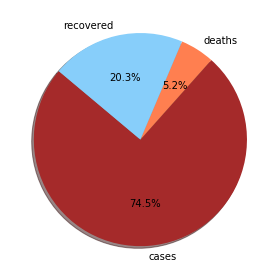

<Figure size 432x288 with 0 Axes>

In [4]:
global_url = "https://coronavirus-19-api.herokuapp.com/all"
response_global_url = requests.get(global_url)
global_df = json_normalize(response_global_url.json(), errors='ignore')
global_df

Global_DF = pd.DataFrame(global_df)
Global_DF

# Filter the DataFrame down only to those columns to chart
pie_chart = Global_DF[["cases","deaths","recovered"]]


# Labels for the sections of our pie chart
labels = ["cases", "deaths", "recovered"]

# The values of each section of the pie chart
sizes = pie_chart

# The colors of each section of the pie chart
colors = ["brown", "coral", "lightskyblue"]

# Tells matplotlib to seperate the section from the others
explode = (0, 0, 0)

# Creates the pie chart based upon the values above
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=140)
plt.tight_layout()
plt.show()

# Save the pie chart
plt.savefig('Global Stats Pie Chart')

In [5]:
#read in .csv file
hospital_data = pd.read_csv("CSV Folder/hospitals.csv")

#set index to state_name
hospital_data.set_index("state_name",inplace=True)

#group dataframe by state_name
hg = hospital_data.groupby('state_name')

#do count of hg dataframe (where it groups by states)to get total count of hospitals, doctors, staff,
#icu beds, and icu beds utilized. Then add each series to new dataframe called 'state_hospital_data'

hg["num_icu_be"].count()
state_hospital_data = pd.DataFrame(hg["num_icu_be"].count())

hospitals = hg["hospital_n"].count()
state_hospital_data["Number of Hospitals"]=hospitals

doctors = hg["num_licens"].count()
state_hospital_data["Number of Doctors"]=doctors

staff = hg["num_staffe"].count()
state_hospital_data["Number of Staff"]=staff

icu_beds = hg["num_icu_be"].count()
state_hospital_data["ICU Beds Available"]=icu_beds

bed_utiliz = hg["bed_utiliz"].count()
state_hospital_data["ICU Beds Utilized"]=bed_utiliz

#drop double num_icu_be column
state_hospital_data.drop("num_icu_be",axis=1, inplace = True)



In [6]:
# reaching out to API to get current overall state data pertaining to cases, tests, hospitalizations, and deaths
states_url = "https://covidtracking.com/api/states"
response3 = requests.get(states_url)
#Turned entire response into a dataframe
US_df = json_normalize(response3.json(), errors='ignore')
#Narrowed df to specific columns of interest 
US_df = US_df.iloc[:,[0,1,8,9,22,16,10,19]]

#Read in a State Name Abbrev CSV so that df's could be joined with different state naming conventions
st_abrev = pd.read_csv("CSV Folder/Covid Analysis Data - StateNameAbrev.csv")

# Replacing the state abbreviation with names for joining to other data
tests_df = st_abrev.merge(US_df, how = 'inner',left_on = "Abbreviation",right_on = "state")

#Droping abbreviation column since no other dataset used abbrev.
tests_df.drop(columns = ["Abbreviation","state"],inplace = True)

#Joined hospital information with the general information
comb1_df= tests_df.merge(state_hospital_data,how = 'inner',left_on = "State",right_on = "state_name")
#comb1_df.drop(columns = "state_name", inplace = True)

#Read in file about rankings of aggressive measures limiting the virus spread
States_Most_Aggressive_Measures_df = pd.read_csv("CSV Folder/States with the Most Aggressive Measures in Limiting Virus Exposure.csv", encoding ='latin-1')

#Joined rankings data
comb2_df = comb1_df.merge(States_Most_Aggressive_Measures_df, how = 'inner', on = 'State' )

#Renamed Column Headers
comb2_df.rename(columns = {"positive":"Positive",
                           "negative":"Negative",
                           "pending":"Pending",
                           "totalTestResults": "Total Tested",
                           "recovered": "Recovered",
                           "hospitalizedCurrently":"Currently Hospitalized",
                           "death": "Total Deaths",
                           "num_icu_be":"ICU Beds",
                           "Prevention & Containment Rank": "Prevention & Containment Rank",
                           "Risk Factors & Infrastructure Rank": "Risk Factors & Infrastructure Rank",
                           "Economic Impact Rank": "Economic Impact Rank"}, inplace = True)

C:\Users\walsh\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


In [7]:
comb2_df.head()

,State,Positive,Negative,Pending,Total Tested,Recovered,Currently Hospitalized,Total Deaths,Number of Hospitals,Number of Doctors,Number of Staff,ICU Beds Available,ICU Beds Utilized,Overall Rank,Prevention & Containment Rank,Risk Factors & Infrastructure Rank,Economic Impact Rank,Delta in Overall Rank vs. March 23
0,Alabama,5465,43295,NaN,48760,NaN,NaN,194.0,120,120,120,66,109,48,48,45,2,-15
1,Alaska,335,11824,NaN,12159,196.0,39.0,9.0,28,28,28,7,23,3,2,11,40,11
2,Arizona,5459,51142,NaN,56601,1265.0,664.0,229.0,126,126,126,46,108,39,36,46,19,-1
3,Arkansas,2276,27437,NaN,29713,863.0,97.0,42.0,106,106,106,40,100,46,45,49,5,1
4,California,35396,429931,NaN,465327,NaN,4984.0,1354.0,466,466,466,302,401,18,15,44,16,-17


In [8]:
# Filter the DataFrame down only to those columns to chart
bar_chart_df = comb2_df[["State","Positive","Negative"]]

# Set the index to be "State" so they will be used as labels
bar_chart_df = bar_chart_df.set_index("State")

bar_chart_df.head()

,Positive,Negative
State,,
Alabama,5465,43295
Alaska,335,11824
Arizona,5459,51142
Arkansas,2276,27437
California,35396,429931


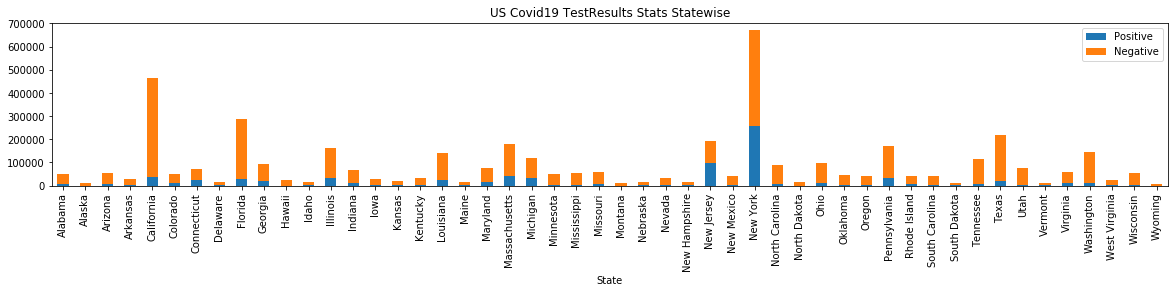

<Figure size 432x288 with 0 Axes>

In [9]:
# Use DataFrame.plot() in order to create a bar chart of the data
bar_chart_df.plot(kind="bar", figsize=(20,3), stacked=True,title = 'US Covid19 TestResults Stats Statewise')

# Display the chart
plt.show()
plt.tight_layout()

# Save the bar chart
plt.savefig('Statewise TestResults Stacked Bar Chart')

In [11]:
# uploading cases/deaths by country and formatting dataframe
countries_url = "https://coronavirus-19-api.herokuapp.com/countries"
response2 = requests.get(countries_url)
Countries_df = json_normalize(response2.json(), errors='ignore')
Countries_df = Countries_df.iloc[Countries_df.index>7,[0,1,2,3,4,5,6,7]] 
Countries_df = Countries_df[Countries_df["country"] != "Total:"]
Countries_df.loc[8,"country"]='United States'
Countries_df
#imported data on SES and created a dataframe
globses = pd.read_csv("CSV Folder/GLOB.csv", encoding = 'latin-1')
globses = globses[globses["year"]==2010]
globses = globses.reset_index(drop = True)

#merged ses data with countries Covid Data
combined_Countries_df_data = pd.merge(Countries_df, globses, how="left", on=["country", "country"])  
combined_Countries_df_data.dropna(inplace =True) 
combined_Countries_df_data.reset_index(inplace = True, drop = True) 

#Clean up column header names
combined_Countries_df_data.rename(columns = {"country":"Country",
                           "cases":"Total Cases",
                           "todayCases":"Cases Today",
                           "deaths": "Deaths",
                           "todayDeaths":"Deaths Today",
                           "recovered":"Total Recovered",
                           "active":"Active Cases",
                           "critical": "Critical",
                           "gdppc": "GDP per Capita",
                           "yrseduc":"Avg Years Education"}, inplace = True)

#read in government type file and inner merge on country
gov_df = pd.read_csv("CSV Folder/Gov_type.csv")
combined_Countries_df_data2 = combined_Countries_df_data.merge(gov_df, how="inner", on="Country") 
combined_Countries_df_data2

C:\Users\walsh\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,Country,Total Cases,Cases Today,Deaths,Deaths Today,Total Recovered,Active Cases,Critical,unid,wbid,year,SES,GDP per Capita,Avg Years Education,popshare,Government Type
0,United States,848994,277,47676,17,84050.0,717268,14016,840.0,USA,2010.0,97.464378,49372.8320,13.0971,0.045907,constitutional federal republic
1,Spain,208389,0,21717,0,85915.0,100757,7705,724.0,ESP,2010.0,85.359718,32506.4340,10.3821,0.006912,parliamentary constitutional monarchy
2,Italy,187327,0,25085,0,54543.0,107699,2384,380.0,ITA,2010.0,85.016357,36201.1600,9.5096,0.008797,parliamentary republic
3,France,159877,0,21340,0,40657.0,97880,5218,250.0,FRA,2010.0,88.194969,36872.2270,10.5329,0.009650,semi-presidential republic
4,Germany,150648,0,5315,0,99400.0,45933,2908,276.0,DEU,2010.0,92.546394,40428.7230,11.8231,0.012136,federal parliamentary republic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Syria,42,0,3,0,6.0,33,0,760.0,SYR,2010.0,37.778469,9227.2402,5.2782,0.003075,presidential republic; highly authoritarian re...
66,Mozambique,41,0,0,0,8.0,33,0,508.0,MOZ,2010.0,1.039163,913.9884,1.7548,0.003609,presidential republic
67,Angola,25,0,2,0,6.0,17,0,24.0,AGO,2010.0,21.247763,6492.1768,2.7900,0.003149,presidential republic
68,Malawi,23,0,3,0,3.0,17,1,454.0,MWI,2010.0,5.964601,1060.7469,4.7003,0.002192,presidential republic


In [12]:
CasesbyCountry = Countries_df.loc[:,["country","cases"]]
CasesbyCountry.sort_values("cases", ascending = False,inplace = True)
CasesbyCountry

,country,cases
8,United States,848994
9,Spain,208389
10,Italy,187327
11,France,159877
12,Germany,150648
...,...,...
214,Sao Tome and Principe,4
215,South Sudan,4
216,Anguilla,3
217,Saint Pierre Miquelon,1


2637673


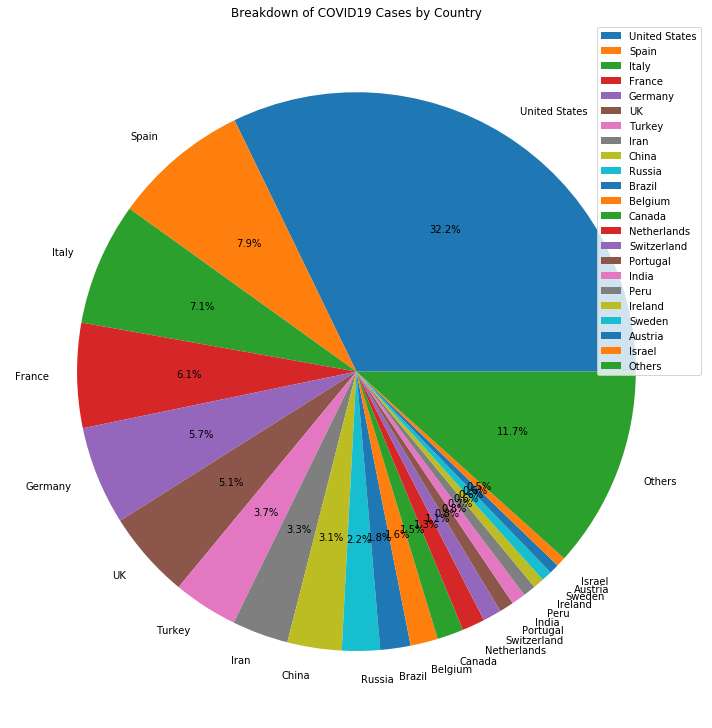

In [24]:
CasesbyCountry = Countries_df.loc[:,["country","cases"]]
CasesbyCountry.sort_values("cases", ascending = False,inplace = True)
CasesbyCountry["Percent of Cases World"]=round(CasesbyCountry["cases"]/(CasesbyCountry["cases"].sum())*100,2)
CasesbyCountry.reset_index(drop = True)
CountryCases =CasesbyCountry ["cases"].sum()
print(CountryCases)
CountryCasesPie = CasesbyCountry[CasesbyCountry["Percent of Cases World"]>.5]
PercentTop = CountryCasesPie["Percent of Cases World"].sum()
PercentOther = (100 - float(PercentTop))
OtherCases = CountryCases - CountryCasesPie["cases"].sum()
Chart = CountryCasesPie.append({"country":"Others","cases":OtherCases,"Percent of Cases World":PercentOther}, ignore_index = True)
labels = Chart["country"]
sizes = Chart ["cases"]
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(sizes,labels = labels, autopct='%1.1f%%')
plt.tight_layout()
plt.title("Breakdown of COVID19 Cases by Country")
plt.legend( loc = 'upper right' )

In [ ]:





OtherCases = CountryCases - CountryCasesPie["Percent of Cases World"].sum()
print(CountryCasesPie["Percent of Cases World"].sum())
print(OtherCases)
print(f" Total Cases in World are {CountryCases} and the percent of states with less than 1% is {PercentOther}")




In [ ]:
# Heatmap Analysis
locations = combined_Countries_df_data2['Country'].values.tolist()
cases = combined_Countries_df_data2['Active Cases'].astype(int)

# Plot Heatmap
fig = Map(center=(0, 0), zoom=2)

# Create Heatmap layer
heatmap = Heatmap(locations=locations, weights=cases, radius=20)

# Add Heatmap layer to map
fig.add_layer(heatmap)

# Display figure
fig.add_layer
#fig

In [ ]:
fig